# Exercise 6 / Quasi-Newton Methods

### Overview

1. Implement DFP method and compare it with first-order methods

1. Implement BFGS method and compare it with first-order methods

1. Analyze error plots of the respective optimization methods applied for different tasks

### Submission

When done, paste your code into the quiz on Moodle and answer the questions.

## Utilities

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from typing import Callable
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from scipy.optimize import minimize

In [2]:
def contour_map(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
    ax=None,
) -> None:
    """Plots the contour lines of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
        ax (optional): The axes to plot on. Defaults to None.
    """
    if ax is None:
        ax = plt
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.contour(xv, yv, values.reshape(nx, ny), 15)


def surface_plot(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
) -> tuple[plt.Figure, Axes3D]:
    """Creates a 3D surface plot of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
    Returns:
        tuple[plt.Figure, Axes3D]: Figure and axis containing the rendered surface.
    """
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.plot_surface(xv, yv, values.reshape(nx, ny), cmap=cm.coolwarm)
    return fig, ax

In [3]:
def backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 0.3,
    beta: float = 0.8,
) -> float:
    """Performs Armijo backtracking line search for a descent direction.

    Args:
        x (NDArray): Current point in parameter space.
        d (NDArray): Candidate descent direction.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        alpha (float, optional): Armijo sufficient decrease parameter. Defaults to 0.3.
        beta (float, optional): Multiplicative shrink factor for the step size. Defaults to 0.8.
    Returns:
        float: Step length that satisfies the Armijo condition.
    """
    step_size = 1.0
    fx = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)

    while f(x + step_size * d) > fx + alpha * step_size * directional_derivative:
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size


def non_descent_backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 1.0,
    beta: float = 0.8,
) -> float:
    """Line search for methods that do not guarantee a descent direction.
    Finds a step size that satisfies a modified sufficient decrease condition.

    Args:
        x (NDArray): The current point.
        d (NDArray): The search direction (not necessarily a descent direction).
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        alpha (float, optional): The parameter of the modified sufficient decrease condition. Defaults to 0.3.
        beta (float, optional): The factor by which to reduce the step size per iteration. Defaults to 0.8.

    Returns:
        float: The step size that satisfies the modified sufficient decrease condition.
    """
    step_size = 1.0
    fx: float = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)
    while (
        f(x + step_size * d)
        > fx + alpha * step_size * directional_derivative + step_size / 2 * d.T @ d
    ):
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size

In [4]:
def gradient_descent_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Collects iterates produced by gradient descent.

    Args:
        x0 (NDArray): Initial point used to seed the algorithm.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        max_iter (int, optional): Maximum number of gradient steps. Defaults to 100.
    Returns:
        list[NDArray]: Sequence of iterates, including the initial point.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        grad = g(x)
        step = backtracking_line_search(x, -grad, f, g)
        x = x - step * grad
        xs.append(x.copy())
    return xs


def heavy_ball_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the Heavy Ball method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        d = -g(current_x) + (i - 1) / (i + 1) * (current_x - prev_x)
        t = non_descent_backtracking_line_search(current_x, d, f, g)
        xs.append(current_x + t * d)

    return xs


def nag_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Nesterov's accelerated gradient method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1, 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        y = current_x + (i - 1) / (i + 2) * (current_x - prev_x)
        d = g(y)
        t = non_descent_backtracking_line_search(y, -d, f, g)
        xs.append(y - t * d)

    return xs


def newtons_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Newton's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        h (Callable[[NDArray], NDArray]): The second gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        d = np.linalg.solve(h(x), -g(x))
        t = backtracking_line_search(x, d, f, g)
        x = x + t * d
        xs.append(x.copy())
    return xs

In [5]:
EXAMPLE_MATRIX = np.array([[30.0, 15], [-20, 25]]) / 20

EXAMPLES = [
    (
        lambda x: x.T @ EXAMPLE_MATRIX @ x + 1,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T) @ x,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T),
        0.5 * np.ones(2),
        (-1.0, 1.0),
        (-1.0, 1.0),
    ),
    (
        lambda x: (x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]),
        lambda x: np.array([2 * x[0] + 4, 60 * x[1]]),
        lambda x: np.array([[2, 0], [0, 60]]),
        np.array([2.0, 3.0]),
        (-5, 5),
        (-4, 4),
    ),
    (
        lambda x: np.linalg.norm(np.sin(x * 3)) ** 2,
        lambda x: 6 * np.sin(x * 3) * np.cos(x * 3),
        lambda x: 18 * np.diag(2 * np.cos(3 * x) ** 2 - 1),
        np.array([0.2, 0.15]),
        (-0.5, 0.5),
        (-0.5, 0.5),
    ),
]


def run_examples(
    optimizer_1: Callable,
    optimizer_name_1: str,
    optimizer_2: Callable,
    optimizer_name_2: str,
    uses_hessian_1: bool = False,
    uses_hessian_2: bool = False,
) -> None:
    """Compares one optimizer to another one.

    Args:
        optimizer_1 (Callable): The optimizer to test.
        optimizer_name_1 (str): Name of the first optimizer.
        optimizer_2: optimizer_path_function_type): The second optimizer to compare against.
        optimizer_name_2 (str): Name of the second optimizer.
        uses_hessian_1 (bool, optional): Whether the first optimizer uses the Hessian function. Defaults to False.
        uses_hessian_2 (bool, optional): Whether the second optimizer uses the Hessian function. Defaults to False.
    """
    for f, g, h, x0, x_bounds, y_bounds in EXAMPLES:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        xs_1 = np.array(
            optimizer_1(x0, f, g, h) if uses_hessian_1 else optimizer_1(x0, f, g)
        )
        xs_2 = np.array(
            optimizer_2(x0, f, g, h) if uses_hessian_2 else optimizer_2(x0, f, g)
        )

        contour_map(f, xb=x_bounds, yb=y_bounds, ax=axs[0])

        axs[0].plot(xs_1[:, 0], xs_1[:, 1], ".--k", label=optimizer_name_1)
        axs[0].plot(
            xs_2[:, 0],
            xs_2[:, 1],
            ".--",
            color="gray",
            alpha=0.5,
            label=optimizer_name_2,
        )

        axs[1].semilogy(
            np.arange(0, len(xs_1)), [f(x) for x in xs_1], label=optimizer_name_1
        )
        axs[1].semilogy(
            np.arange(0, len(xs_2)), [f(x) for x in xs_2], label=optimizer_name_2
        )

        axs[0].legend()
        axs[1].legend()
        axs[1].set_xlabel("iteration")
        axs[1].set_ylabel("f(x_t)")

        plt.show()

## Task 1: DFP method

Implement the DFP method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `dfp_path` should return a list of vectors on the path to the minimum.

In [49]:
def dfp_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the DFP (Davidon-Fletcher-Powell) quasi-Newton method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement DFP quasi-Newton method using the provided backtracking line search

    # raise NotImplementedError
    # eps = 0.000000001
    # x = np.array(x0, dtype=float, copy=True)
    xs = [x0.copy()]
    H = np.eye(x0.shape[0])
    Hs = [H] # first Hessian as identity; H=inv(B)
    for i in range(max_iter):
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        y = g(x0) - g(prev_x)
        # y *= 3
        # y[-1] -= 1
        s = x0 - prev_x + 1
        # s *= 2
        print('s', s)
        print('y', y)
        print('H', H)
        print('s', s.shape)
        print('y', y.shape)
        print('H', H.shape)
        print()
        # rho = 1 / y.T.dot(s)
        num1 = (H @ y)
        print(num1)
        # num1 = np.outer(num1, y.T) @ H.T
        num1 = np.outer(num1, y.T)
        print(num1)
        num1 = num1 @ H.T
        # num1 = (H @ y @ y.T @ H.T)
        print('num1', num1.shape)
        print(num1)
        print()
        denom1 = (y.T @ H)
        print(denom1)
        denom1 = denom1 @ y
        print('denom1', denom1.shape)
        print(denom1)
        print()
        num2 = np.outer(s, s.T)
        print(num2)
        print('num2', num2.shape)
        print()
        denom2 = (y.T @ s)
        print('denom2')
        # H -= (H @ y @ y.T @ H.T) / (y.T @ H @ y) + (s @ s.T) / (y.T @ s)
        H -= np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
        # H -= num1 / denom1 + num2 / denom2
        print()
        print(H)
        d = H
        bls = backtracking_line_search(x0, -g(x0), f, g)
        x0 += bls * d
        xs.append(x0.copy())
    return xs

s [1. 1.]
y [0. 0.]
H [[1. 0.]
 [0. 1.]]
s (2,)
y (2,)
H (2, 2)

[0. 0.]
[[0. 0.]
 [0. 0.]]
num1 (2, 2)
[[0. 0.]
 [0. 0.]]

[0. 0.]
denom1 ()
0.0

[[1. 1.]
 [1. 1.]]
num2 (2, 2)

denom2

[[nan nan]
 [nan nan]]


C:\Users\admin\AppData\Local\Temp\ipykernel_14596\1050335011.py:64: RuntimeWarning: invalid value encountered in divide
  H -= np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
C:\Users\admin\AppData\Local\Temp\ipykernel_14596\1050335011.py:64: RuntimeWarning: divide by zero encountered in divide
  H -= np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)


ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (2,2)

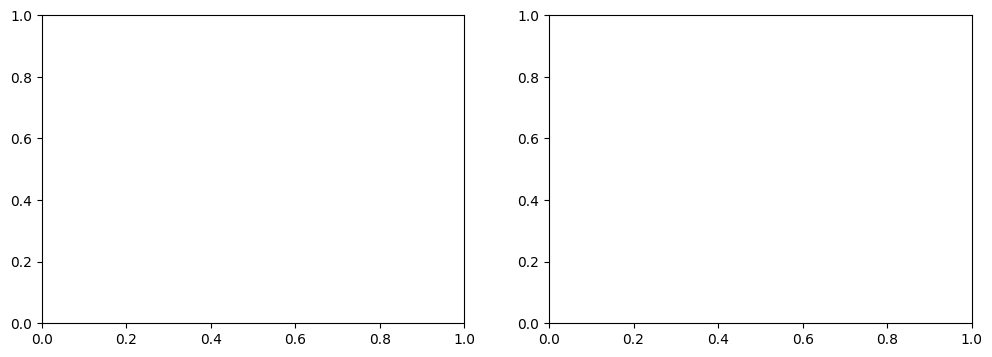

In [50]:
# run this to get plots
run_examples(
    optimizer_1=dfp_path,
    optimizer_name_1="dfp",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

## Task 2: BFGS method

Implement the BFGS method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `bfgs_path` should return a list of vectors on the path to the minimum.

In [ ]:
def bfgs_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the BFGS (Broyden-Fletcher-Goldfarb-Shanno) quasi-Newton method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement BFGS quasi-Newton method using the provided backtracking line search

    raise NotImplementedError

In [ ]:
# run this to get plots
run_examples(
    optimizer_1=bfgs_path,
    optimizer_name_1="bfgs",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

## Task 3: Error plots

Then compare and plot the error over time for the optimization methods on the following tasks.
Implementations of the prior methods are given in the Utils section.

In [ ]:
def plot_error(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    x_star: NDArray,
) -> None:
    """Compares the difference between optimum and function value along the paths of gradient descent, heavy ball and Nesterov's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        x_star (NDArray): The optimal solution.
    """
    ball = heavy_ball_path(x0, f, g)
    nest = nag_path(x0, f, g)
    gd = gradient_descent_path(x0, f, g)
    newt = newtons_path(x0, f, g, h)
    dfp = dfp_path(x0, f, g)
    bfgs = bfgs_path(x0, f, g)

    def errors(path: list[NDArray]) -> NDArray:
        return np.array([f(x) for x in path]) - f(x_star)

    plt.semilogy(
        np.arange(len(gd)),
        errors(gd),
        label="gradient descent",
    )
    plt.semilogy(
        np.arange(len(ball)),
        errors(ball),
        label="heavy ball",
    )
    plt.semilogy(
        np.arange(len(nest)),
        errors(nest),
        label="nesterov",
    )
    plt.semilogy(
        np.arange(len(newt)),
        errors(newt),
        label="newton's",
    )
    plt.semilogy(
        np.arange(len(dfp)),
        errors(dfp),
        label="dfp",
    )
    plt.semilogy(
        np.arange(len(bfgs)),
        errors(bfgs),
        label="bfgs",
    )

    plt.legend()
    plt.show()

### Simple quadratic function

In [ ]:
def f(x):
    return x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]


def g(x):
    return np.array([2 * x[0] + 4, 60 * x[1]])


def h(x):
    return np.array([[2, 0], [0, 60]])


x0 = np.array([2.0, 3.0])
x_star = np.array([-2.0, 0.0])

plot_error(x0, f, g, h, x_star)

### Ill-conditioned quadratic

In [ ]:
n = 50
rng = np.random.default_rng(seed=42)
Q = rng.standard_normal((n, n))
Q = Q.T @ Q
U, _ = np.linalg.qr(Q)

A = U @ np.diag(np.linspace(1, 1000, n)) @ U.T
b = rng.standard_normal(n)


def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x


def g(x):
    return A @ x - b


def h(x):
    return A


x0 = np.zeros(n)
x_star = np.linalg.solve(A, b)

plot_error(x0, f, g, h, x_star)

### Linear regression

In [ ]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)


def g(w):
    return 2 * X.T @ (X @ w - y) / len(X)


def h(w):
    return 2 * X.T @ X / len(X)


X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)
x0 = np.zeros(100)

x_star = np.linalg.lstsq(X, y, rcond=None)[0]

plot_error(x0, f, g, h, x_star)

### Logistic regression


In [ ]:
def f(w):
    return np.log(1.0 + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w) ** 2


def g(w):
    sig = np.exp(-y * X.dot(w))
    return 2 * w - X.T.dot(sig * y / (sig + 1.0)) / X.shape[0]


def h(w):
    X_rows, w_rows = X.shape
    t_0 = np.exp(-(y * (X).dot(w)))
    t_1 = t_0 * y
    t_2 = np.ones(X_rows) + t_0
    hess = (2 * np.eye(w_rows, w_rows)) - 1 / X_rows * (
        (((((t_1 * t_0) * y) / (t_2 * t_2))[:, np.newaxis] * X).T).dot(X)
        - (((((y * t_0) * y) / t_2)[:, np.newaxis] * X).T).dot(X)
    )
    return hess


X, y = make_classification(
    1000,
    80,
    n_informative=40,
    # n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0,
)

x0 = np.zeros(80)
x_star = minimize(f, x0, jac=g).x

plot_error(x0, f, g, h, x_star)